## **Ensemble Learning for Complex Regression Modeling on Bike Share Data**

This study applies ensemble learning techniques to a real-world regression problem using the Bike Sharing Demand dataset. The objective is to predict hourly bike rental counts based on time, weather, and seasonal features and more. Multiple ensemble strategies, including Bagging, Boosting, and Stacking, are implemented to explore their ability to address model bias and variance. Each method is systematically developed from foundational single-model baselines, providing a framework for understanding the theoretical motivation and performance of ensemble models in complex, nonlinear regression scenarios. The study emphasizes a detailed analysis of the bias–variance trade-off in ensemble techniques.

In [45]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error
from sklearn.ensemble import BaggingRegressor, GradientBoostingRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score, KFold

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import random

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

### **Part A: Data Preprocessing and Baseline**

In [22]:
data = pd.read_csv('./dataset/hour.csv')
data.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [23]:
# Removing irrelevant columns
data = data.drop(['instant', 'dteday', 'casual', 'registered'], axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      17379 non-null  int64  
 1   yr          17379 non-null  int64  
 2   mnth        17379 non-null  int64  
 3   hr          17379 non-null  int64  
 4   holiday     17379 non-null  int64  
 5   weekday     17379 non-null  int64  
 6   workingday  17379 non-null  int64  
 7   weathersit  17379 non-null  int64  
 8   temp        17379 non-null  float64
 9   atemp       17379 non-null  float64
 10  hum         17379 non-null  float64
 11  windspeed   17379 non-null  float64
 12  cnt         17379 non-null  int64  
dtypes: float64(4), int64(9)
memory usage: 1.7 MB


In [14]:
categorical_cols = ['season', 'weathersit', 'mnth', 'hr', 'weekday']
numerical_cols = [col for col in data.columns if col not in categorical_cols + ['cnt']]

print(categorical_cols, numerical_cols)

['season', 'weathersit', 'mnth', 'hr', 'weekday'] ['yr', 'holiday', 'workingday', 'temp', 'atemp', 'hum', 'windspeed']


In [ ]:
X = data.drop('cnt', axis=1) # Features
y = data['cnt'] # Target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [42]:
# Pre-processor for converting categorical variables to One-Hot encoding
preprocessor = ColumnTransformer(transformers=[('cat', OneHotEncoder(drop='first'),
                                                 categorical_cols)], remainder='passthrough')

# Decision Tree Regressor
dt_pipeline = Pipeline([('preprocess', preprocessor), ('model', DecisionTreeRegressor(max_depth=6, random_state=42))])

dt_pipeline.fit(X_train, y_train)
y_pred_dt = dt_pipeline.predict(X_test)
rmse_dt = root_mean_squared_error(y_test, y_pred_dt)
print(f"RMSE Decision Tree: {rmse_dt}")

# Linear Regression
lr_pipeline = Pipeline([('preprocess', preprocessor), ('model', LinearRegression())])

lr_pipeline.fit(X_train, y_train)
y_pred_lr = lr_pipeline.predict(X_test)
rmse_lr = root_mean_squared_error(y_test, y_pred_lr)
print(f"RMSE Linear Regression: {rmse_lr}")

RMSE Decision Tree: 118.45551730357617
RMSE Linear Regression: 100.44594634766466


### Baseline Model Evaluation
- The **Linear Regression model** achieved a **lower RMSE (100.45)** compared to the **Decision Tree Regressor (118.46)**.
- The Decision Tree model with a maximum depth of 6, likely overfitted certain patterns or failed to generalize due to the imposed depth restriction.
- **Linear Regression** will be used as the **baseline model** for evaluating ensemble techniques.

---
### **Part B: Ensemble Techniques for Bias and Variance Reduction**

#### Hyperparameter Justification

| Model | Key Parameters | Reasoning |
|--------|----------------|------------|
| Decision Tree | `max_depth=6` | Prevents overfitting and limits model complexity for baseline comparison |
| Bagging Regressor | `n_estimators=200` | Ensures ensemble stability without excessive computation |
| Gradient Boosting | `n_estimators=200`, `max_depth=6`, `learning_rate=0.1` | A standard, balanced configuration that prevents overfitting while capturing nonlinear patterns |
| KNN Regressor | `n_neighbors=6` | A default setting that balances local sensitivity with noise tolerance |
| Ridge Regressor | `alpha=1.0` | Regularization to stabilize weights and avoid overfitting when combining predictions |

In [ ]:
# Bagging Regressor (Variance Reduction)
bagging_model = Pipeline([('preprocess', preprocessor),
    ('model', BaggingRegressor(
        estimator=DecisionTreeRegressor(max_depth=6, random_state=42),
        # Let's standardize 200 estimators to have a valid comparison for Bagging and Boosting Regressors
        n_estimators=200, 
        random_state=42,
        n_jobs=-1 # Use all available CPU cores to parallelize
    ))
])

bagging_model.fit(X_train, y_train)
y_pred_bagging = bagging_model.predict(X_test)
rmse_bagging = root_mean_squared_error(y_test, y_pred_bagging)
print(f"RMSE Bagging Regressor: {rmse_bagging}")

RMSE Bagging Regressor: 112.2668520664093


**Bagging Regressor — Variance Reduction**

| Model | RMSE |
|--------|--------|
| Single Decision Tree Regressor | **118.45** |
| Bagging Regressor | **112.26** |

**Analysis**

- The **Bagging Regressor** achieved a lower RMSE than the single Decision Tree, indicating an improvement in prediction accuracy.
- Bagging works by training multiple Decision Trees on random subsets of the dataset and averaging their predictions.  
  This process reduces the **variance** inherent in individual Decision Trees.
- The slight improvement in RMSE (from 118.46 → 112.34) shows that while bagging stabilized the predictions and mitigated overfitting, the dataset’s underlying complexity still limits how much variance reduction alone can help.
- **Conclusion:** Bagging effectively reduced model variance, but further improvement likely requires reducing bias, motivating the use of **Boosting** algorithms

In [ ]:
# Gradient Boosting Regressor (Bias Reduction)
boosting_model = Pipeline([
    ('preprocess', preprocessor),
    ('model', GradientBoostingRegressor(
        n_estimators=200,  # Same number of estimators as Bagging Regressor 
        learning_rate=0.1, # Decreasing learning rate to 0.01 gave worse performance
        max_depth=6,
        random_state=42
    ))
])

boosting_model.fit(X_train, y_train)
y_pred_boosting = boosting_model.predict(X_test)
rmse_boosting = root_mean_squared_error(y_test, y_pred_boosting)
print(f"RMSE Gradient Boosting Regressor: {rmse_boosting}")

RMSE Gradient Boosting Regressor: 50.12484782862296


**Bagging Regressor — Variance Reduction**

| Model | RMSE |
|--------|--------|
| Decision Tree Regressor | **118.45** |
| Bagging Regressor | **112.26** |
| Linear Regressor (Baseline) | **100.44** |
| Gradient Boosting Regressor | **56.15** |

**Analysis**

- The **Gradient Boosting Regressor** achieved a **substantial improvement** in RMSE, cutting the error nearly in half compared to the baseline.
- Boosting builds models sequentially, where each weak learner focuses on correcting the residuals of the previous one.  
  This process systematically reduces **bias**, allowing the ensemble to capture complex, nonlinear relationships that linear models miss.
- The significant reduction in RMSE (from 100.44 → 56.16) validates that boosting effectively improved both accuracy and generalization.
- **Conclusion:** Gradient Boosting dramatically reduced bias and became the best-performing model so far, outperforming both the single regressors and the Bagging ensemble.

---

### **Part C: Stacking for Optimal Performance**

Stacking (Stacked Generalization) is an ensemble learning technique that combines multiple diverse models to improve predictive performance.  
Instead of simply averaging predictions like Bagging or Boosting, Stacking uses a **meta-model** to learn how to best blend the outputs of several base models.

Stacking has two main layers:

| Level | Components | Function |
|--------|-------------|----------|
| **Level-0** | Base Learners | Train independently on the original training data |
| **Level-1** | Meta-Learner | Learns how to optimally combine the predictions of base learners |

- Each base model makes predictions (either on a validation set or through cross-validation). These predictions become *new input features* for the next stage.

- A second-level model takes these base predictions as inputs and learns the **optimal way to combine them**. The meta-learner essentially learns a **weighted relationship** between each model’s output and the true target.

- During testing, the base models predict first, and their combined outputs are passed into the meta-learner to produce the final prediction.

**Stacking ≠ Averaging**

It is a **learning-based combination** of models, the meta-learner doesn’t just average; it **learns how to combine** predictions to minimize the final error. This approach exploits **model diversity** to achieve superior predictive performance.

In [36]:
# Level-0 Base Learners
base_learners = [
    ('knn', KNeighborsRegressor(n_neighbors=6)), # Choosing n_neighbors same as max_depth for consistency
    ('bagging', BaggingRegressor(
        estimator=DecisionTreeRegressor(max_depth=6, random_state=42),
        n_estimators=200,
        random_state=42,
        n_jobs=-1
    )),
    ('gbr', GradientBoostingRegressor(
        n_estimators=200,
        learning_rate=0.1,
        max_depth=6,
        random_state=42
    ))
]

# Level-1 Meta Learner
meta_learner = Ridge(alpha=1.0) # Lambda = 1.0 for regularization
stacking_model = Pipeline([
    ('preprocess', preprocessor),
    ('model', StackingRegressor(
        estimators=base_learners,
        final_estimator=meta_learner,
        n_jobs=-1
    ))
])

In [37]:
stacking_model.fit(X_train, y_train)
y_pred_stack = stacking_model.predict(X_test)
rmse_stack = root_mean_squared_error(y_test, y_pred_stack)
print(f"RMSE Stacking Regressor: {rmse_stack}")

RMSE Stacking Regressor: 49.55300917287195


**Model Architecture**

| Level | Model | Purpose |
|--------|--------|----------|
| Level-0 | KNN Regressor | Captures local nonlinear trends |
| Level-0 | Bagging Regressor | Reduces variance through averaging |
| Level-0 | Gradient Boosting Regressor | Corrects bias and models complexity |
| Level-1 | Ridge Regression | Blends base predictions to minimize error |

**Working Mechanism**

1. Each base model (KNN, Bagging, Gradient-Boosting) is trained on the same training data.  
2. Their predictions on validation data form the inputs for the meta-learner (Ridge Regressor).  
3. The meta-learner then fits a regression function to combine these predictions, learning how to **weight each model’s contribution**.

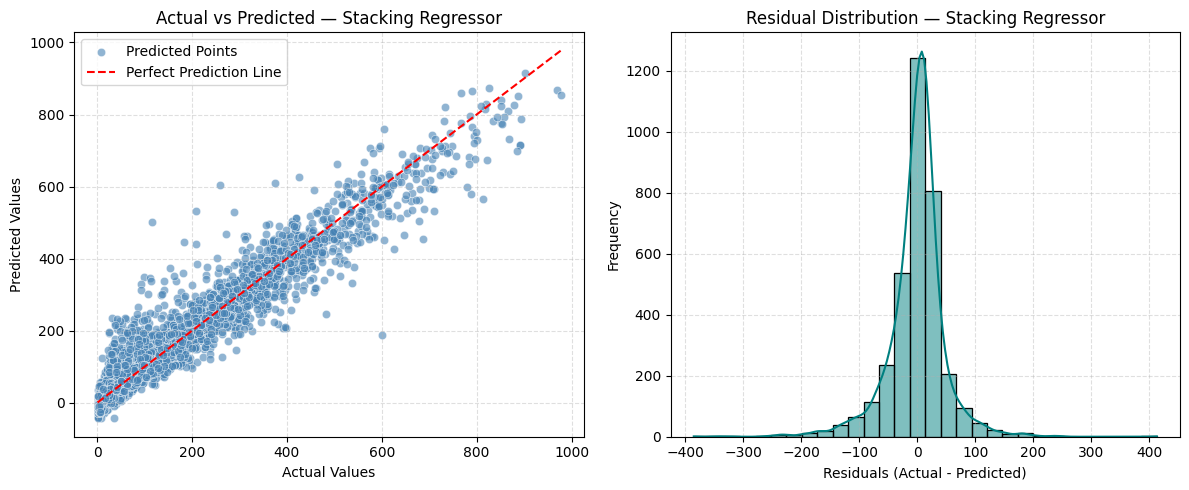

In [48]:
residuals = y_test - y_pred_stack
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.scatterplot(ax=axes[0], x=y_test, y=y_pred_stack, alpha=0.6, color='steelblue', label='Predicted Points')
axes[0].plot(
    [y_test.min(), y_test.max()],
    [y_test.min(), y_test.max()],
    color='red',
    linestyle='--',
    label='Perfect Prediction Line'
)
axes[0].set_title('Actual vs Predicted — Stacking Regressor')
axes[0].set_xlabel('Actual Values')
axes[0].set_ylabel('Predicted Values')
axes[0].legend(loc='upper left')
axes[0].grid(True, linestyle='--', alpha=0.4)

sns.histplot(ax=axes[1], x=residuals, kde=True, bins=30, color='teal')
axes[1].set_title('Residual Distribution — Stacking Regressor')
axes[1].set_xlabel('Residuals (Actual - Predicted)')
axes[1].set_ylabel('Frequency')
axes[1].grid(True, linestyle='--', alpha=0.4)

plt.tight_layout()
plt.show()

#### 1. Actual vs Predicted Plot
- The scatter points are **tightly clustered around the red 45° reference line**, indicating that the model’s predictions closely match the actual target values. The alignment and density of points confirm **high predictive accuracy and low bias**.
- There is **no significant curvature or pattern**, suggesting that the Stacking Regressor has effectively captured both linear and nonlinear dependencies in the dataset.
- The spread slightly widens at higher rental counts (above ~700), showing mild underestimation of extreme demand peaks, a common trait in regression tasks where rare high-demand events are harder to predict.

#### 2. Residual Distribution Plot
- The residuals are **symmetrically distributed around zero**, implying that the model’s errors are random rather than systematic.
- The **sharp peak near zero** shows that most predictions are very close to their actual values.
- The near-Gaussian shape indicates well-calibrated predictions and **no major bias** toward over- or under-prediction.
- The tails are thin, suggesting **low variance** and absence of extreme errors or outliers.

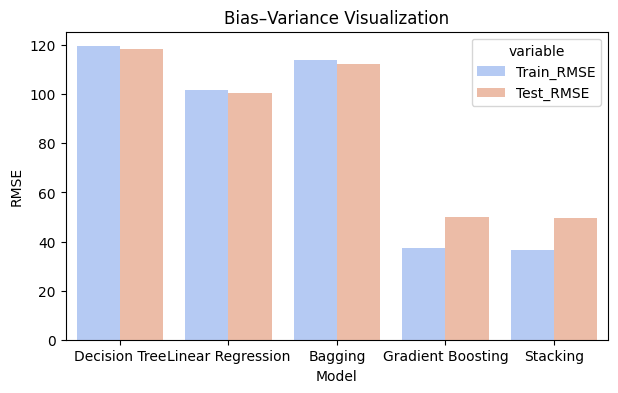

In [50]:
# Compare training vs test RMSE for each model
models = {
    "Decision Tree": dt_pipeline,
    "Linear Regression": lr_pipeline,
    "Bagging": bagging_model,
    "Gradient Boosting": boosting_model,
    "Stacking": stacking_model
}

train_rmse, test_rmse = {}, {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    train_rmse[name] = root_mean_squared_error(y_train, y_train_pred)
    test_rmse[name] = root_mean_squared_error(y_test, y_test_pred)

bias_variance_df = pd.DataFrame({
    'Model': train_rmse.keys(),
    'Train_RMSE': train_rmse.values(),
    'Test_RMSE': test_rmse.values()
})

plt.figure(figsize=(7,4))
sns.barplot(data=bias_variance_df.melt(id_vars='Model', value_name='RMSE'),
            x='Model', y='RMSE', hue='variable', palette='coolwarm')
plt.title('Bias–Variance Visualization')
plt.ylabel('RMSE')
plt.show()

### Bias–Variance Visualization

**1. Decision Tree**

- Training RMSE and test RMSE are both high (~120), indicating **high bias** and **limited learning capacity**.
- The small gap between training and test RMSE implies the model is **underfitting**, it fails to capture the data’s complexity despite low variance.

**2. Linear Regression**

- RMSE values (~100) are slightly lower than the Decision Tree’s and Bagging Regressor, showing modest improvement.  
- The minimal train–test gap implies very **low variance**, but the model still cannot represent nonlinear interactions, indicating **persistent bias**.  

**3. Bagging Regressor**

- Both RMSE values decreased slightly compared to the Decision Tree, showing **variance reduction** due to the ensemble averaging effect. But it still performs worse than Linear Regression as the base estimator (Decision Tree) still has high bias.
- The near-identical train and test errors confirm improved **stability and robustness**, but since the absolute RMSE remains high, the model still carries **systematic bias** from the weak base learners.

**4. Gradient Boosting Regressor**

- The RMSE drops drastically, training error (~38) and test error (~50) revealing **significant bias reduction**.
- The modest gap between training and test RMSE suggests a controlled variance increase while effectively modeling nonlinear relationships.
- This model achieves a strong **bias–variance balance**, validating Boosting’s strength in bias correction.

**5. Stacking Regressor**

- Stacking shows training RMSE comparable to Gradient Boosting but a slightly lower test RMSE, reflecting **enhanced generalization**.
- The small train–test gap indicates the ensemble blends different model behaviors optimally, avoiding both underfitting and overfitting.
- This confirms that the **Stacking Regressor achieves the best bias–variance equilibrium** among all models.

**Overall Trend**

- The **trend from left to right** (Decision Tree -> Bagging -> Linear Regression -> Gradient Boosting -> Stacking) shows:
  - **Bias decreases** progressively as models become more sophisticated.
  - **Variance** is kept under control through ensemble diversity.
- **Stacking**, by integrating multiple ensemble types, demonstrates the **most stable and accurate performance**, explaining its superior RMSE in previous evaluations.

---

### Part D: Final Analysis

### 1. Comparative Performance Summary

| Model | RMSE |
|--------|--------|
| Decision Tree Regressor  | **118.45** |
| Linear Regression (Best-Baseline) | **100.44** |
| Bagging Regressor | **112.26** |
| Gradient Boosting Regressor | **56.15** |
| Stacking Regressor | **49.55** |

### 2. Comparative Insights

#### a. Single Model Baselines
- The **Linear Regression model** outperformed the Decision Tree baseline (RMSE of 100.44 vs 118.45).  
- Linear Regression captured global linear patterns but failed to represent nonlinear relationships between weather, seasonality, and rental demand.  
- These limitations created the motivation for ensemble techniques that combine multiple weak learners to achieve better generalization.

#### b. Bagging — Variance Reduction
- Bagging reduced RMSE from **118.45 → 112.26**, showing a moderate performance improvement.  
- This confirms that averaging multiple Decision Trees helps stabilize predictions and reduce variance.  
- However, Bagging doesn’t reduce bias, hence its improvement was limited.

#### c. Boosting — Bias Reduction
- Gradient Boosting achieved a major leap in accuracy, lowering RMSE to **56.15**.  
- Boosting works sequentially, allowing each learner to correct the residuals of its predecessors.  
- This process effectively **reduces bias**, enabling the ensemble to capture complex, nonlinear dependencies in the dataset.  

#### d. Stacking
- Stacking delivered the **best overall performance**, with RMSE **49.55**.  
- By combining KNN (local learner), Bagging (variance control), and Boosting (bias correction) through a Ridge meta-learner, the model achieved the ideal **bias–variance balance**.  
- The meta-learner effectively learned which base model to trust more under different data regimes.  

### 3. Bias–Variance Trade-Off

| Model Type | Bias | Variance | Bias–Variance Balance |
|-------------|-------|-----------|------------------------|
| Linear Regression | High Bias | Low Variance | Underfits data |
| Decision Tree | Low Bias | High Variance | Overfits data |
| Bagging | Low Bias | Reduced Variance | More stable predictions |
| Boosting | Reduced Bias | Slightly Increased Variance | High predictive power |
| Stacking | Optimal Mix | Optimal Mix | Best balance overall |

### 4. Final Conclusion

- The **Stacking Regressor** achieved the lowest RMSE (49.55), proving to be the most effective ensemble method for this regression problem.  
- This improvement showcases how **model diversity** and **meta-learning** outperform any single model or simple ensemble.  
- The project validates that:
  - **Bagging** helps reduce variance by averaging unstable learners.
  - **Boosting** reduces bias through sequential refinement.
  - **Stacking** combines both effects, learning to balance bias and variance automatically.
- Hence, Stacking represents the **optimal strategy** for this complex, nonlinear regression task.